In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd

In [9]:
data_dir = "C:/Users/akhip/OneDrive/Desktop/Data 441"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")
print(classes)

image_size = 32 * 32

['AdvMachineLearning', 'asl_alphabet_test', 'asl_alphabet_train', 'HW1.ipynb', 'Introduction,_PyTorch_vs_NumPy.ipynb', 'train.ipynb']
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
transform = tt.Compose(
    [tt.Resize(32), tt.ToTensor(), tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = ImageFolder(data_dir + "/asl_alphabet_train/asl_alphabet_train", transform)

In [11]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[-0.7255, -0.6392, -0.6157,  ...,  0.1529,  0.1686,  0.0588],
         [-0.5451, -0.4039, -0.4039,  ...,  0.4039,  0.4431,  0.3098],
         [-0.3725, -0.1922, -0.2000,  ...,  0.2235,  0.2392,  0.1059],
         ...,
         [-0.1922,  0.0902,  0.1137,  ...,  0.2000,  0.1843,  0.0510],
         [-0.1843,  0.0902,  0.1059,  ...,  0.1843,  0.1765,  0.0353],
         [-0.2863, -0.0353, -0.0196,  ...,  0.0588,  0.0353, -0.0824]],

        [[-0.7804, -0.7098, -0.6941,  ...,  0.0353,  0.0588, -0.0431],
         [-0.6235, -0.5137, -0.5294,  ...,  0.2235,  0.2863,  0.1843],
         [-0.4275, -0.2627, -0.3020,  ..., -0.0431, -0.0196, -0.1137],
         ...,
         [-0.1765,  0.0902,  0.1059,  ...,  0.1216,  0.0980, -0.0353],
         [-0.1765,  0.0980,  0.1137,  ...,  0.1059,  0.0980, -0.0431],
         [-0.2549, -0.0196, -0.0039,  ..., -0.0275, -0.0353, -0.1529]],

        [[ 0.0196, -0.3020, -0.2863,  ...,  0.4196,  0.4588,  0.5059],
         [-0.2157, -0.6549, -0.6784,  ...,  0

In [12]:
def show_example(img, label):
    print("Label: ", dataset.classes[label], "(" + str(label) + ")")
    plt.imshow((img.permute(1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  A (0)


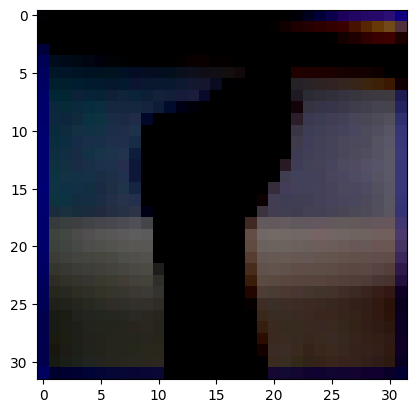

In [14]:
show_example(*dataset[0])

In [16]:
random_seed = 42
torch.manual_seed(random_seed)
print(len(dataset))

87000


In [17]:
val_size = 7000
test_size = 14000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

66000 7000 14000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  A (0)


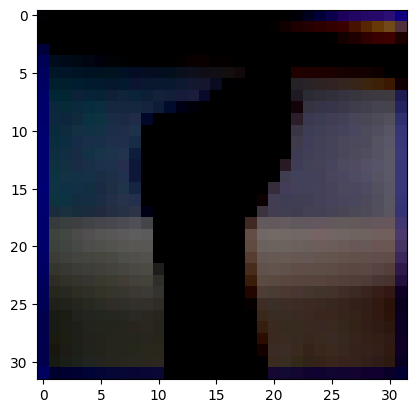

In [18]:
show_example(*dataset[0])

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cpu')

In [21]:
batch_size = 64

train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [23]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


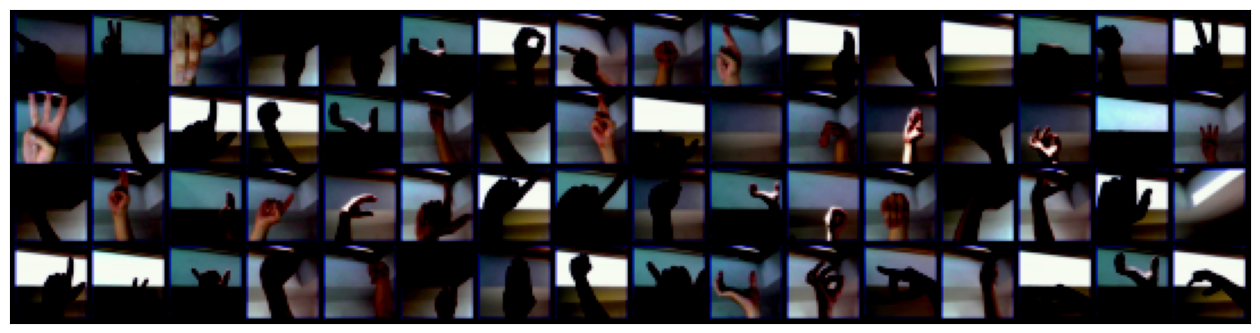

In [24]:
show_batch(train_dl)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class ASLDeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(), nn.Linear(128, output_size)
        )

    def forward(self, xb):
        return self.network(xb.view(xb.size(0), -1))

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["train_loss"], result["val_loss"], result["val_acc"]
            )
        )

In [27]:
input_size = 3 * 32 * 32
output_size = 29
DNN = ASLDeepNeuralNetwork(input_size, output_size)

In [28]:
DNN

ASLDeepNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=29, bias=True)
  )
)

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(DNN, device)

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
img, label = val_ds[0]
print(img.shape)
evaluate(DNN, val_dl)

torch.Size([3, 32, 32])


{'val_loss': 3.372145414352417, 'val_acc': 0.03824896737933159}

In [32]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [33]:
history = fit(num_epochs, lr, DNN, train_dl, val_dl, opt_func)

100%|██████████| 1032/1032 [03:10<00:00,  5.42it/s]


Epoch [0], train_loss: 2.4128, val_loss: 1.9458, val_acc: 0.4575


100%|██████████| 1032/1032 [00:41<00:00, 24.97it/s]


Epoch [1], train_loss: 1.7091, val_loss: 1.5316, val_acc: 0.5710


100%|██████████| 1032/1032 [00:39<00:00, 26.33it/s]


Epoch [2], train_loss: 1.3875, val_loss: 1.2914, val_acc: 0.6361


100%|██████████| 1032/1032 [00:45<00:00, 22.52it/s]


Epoch [3], train_loss: 1.1757, val_loss: 1.0977, val_acc: 0.7070


100%|██████████| 1032/1032 [00:36<00:00, 28.21it/s]


Epoch [4], train_loss: 1.0160, val_loss: 0.9639, val_acc: 0.7413


100%|██████████| 1032/1032 [00:37<00:00, 27.50it/s]


Epoch [5], train_loss: 0.8903, val_loss: 0.8498, val_acc: 0.7783


100%|██████████| 1032/1032 [00:37<00:00, 27.88it/s]


Epoch [6], train_loss: 0.7897, val_loss: 0.7577, val_acc: 0.8049


100%|██████████| 1032/1032 [00:37<00:00, 27.68it/s]


Epoch [7], train_loss: 0.7052, val_loss: 0.6826, val_acc: 0.8283


100%|██████████| 1032/1032 [00:38<00:00, 27.07it/s]


Epoch [8], train_loss: 0.6355, val_loss: 0.6236, val_acc: 0.8404


100%|██████████| 1032/1032 [00:38<00:00, 26.73it/s]


Epoch [9], train_loss: 0.5763, val_loss: 0.5657, val_acc: 0.8600


In [34]:
evaluate(DNN, test_dl)

{'val_loss': 0.5854665637016296, 'val_acc': 0.8521780371665955}

In [35]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")


def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

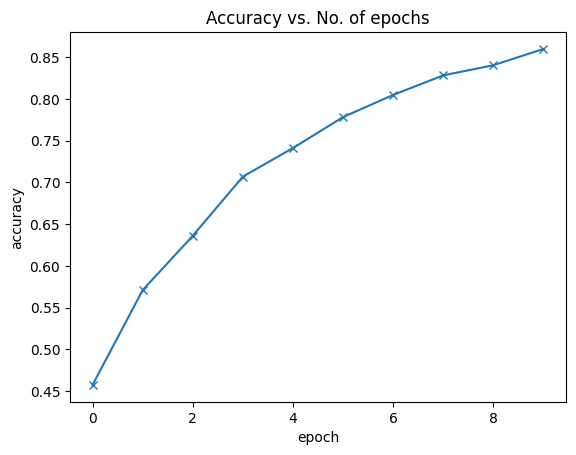

In [36]:
plot_accuracies(history)

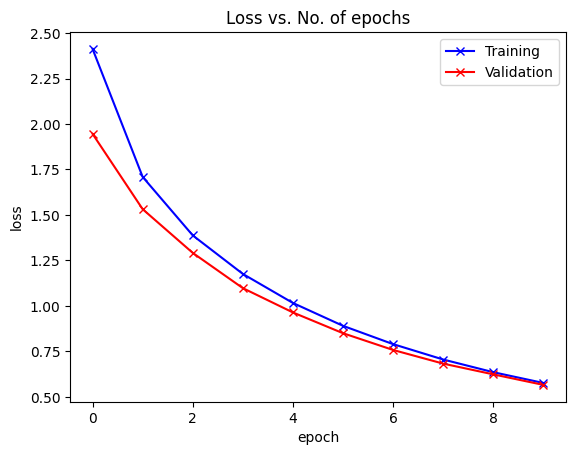

In [37]:
plot_losses(history)

In [38]:
torch.save(DNN.state_dict(), "DNN.pth")

In [39]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )

In [40]:
class ASLModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 16 x 16
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 512 x 4 x 4
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 29),
        )

    def forward(self, xb):
        return self.network(xb)

In [42]:
model = ASLModel()
to_device(model, device)
model

ASLModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=8192, out_features=1024, bias=True)
    (

In [43]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
model = to_device(ASLModel(), device)

In [45]:
evaluate(model, val_dl)

{'val_loss': 3.367631435394287, 'val_acc': 0.03314824402332306}

In [46]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [47]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████| 1032/1032 [21:21<00:00,  1.24s/it]


Epoch [0], val_loss: 0.2499, val_acc: 0.9131


100%|██████████| 1032/1032 [52:44<00:00,  3.07s/it] 


Epoch [1], val_loss: 0.1592, val_acc: 0.9487


100%|██████████| 1032/1032 [22:02<00:00,  1.28s/it]


Epoch [2], val_loss: 0.0582, val_acc: 0.9800


100%|██████████| 1032/1032 [20:51<00:00,  1.21s/it]


Epoch [3], val_loss: 0.0711, val_acc: 0.9752


100%|██████████| 1032/1032 [20:47<00:00,  1.21s/it]


Epoch [4], val_loss: 0.0482, val_acc: 0.9874


100%|██████████| 1032/1032 [21:07<00:00,  1.23s/it]


Epoch [5], val_loss: 0.0757, val_acc: 0.9781


100%|██████████| 1032/1032 [21:05<00:00,  1.23s/it]


Epoch [6], val_loss: 0.0233, val_acc: 0.9952


100%|██████████| 1032/1032 [20:51<00:00,  1.21s/it]


Epoch [7], val_loss: 0.0266, val_acc: 0.9938


100%|██████████| 1032/1032 [21:11<00:00,  1.23s/it]


Epoch [8], val_loss: 0.0173, val_acc: 0.9947


100%|██████████| 1032/1032 [21:06<00:00,  1.23s/it]


Epoch [9], val_loss: 0.0095, val_acc: 0.9972


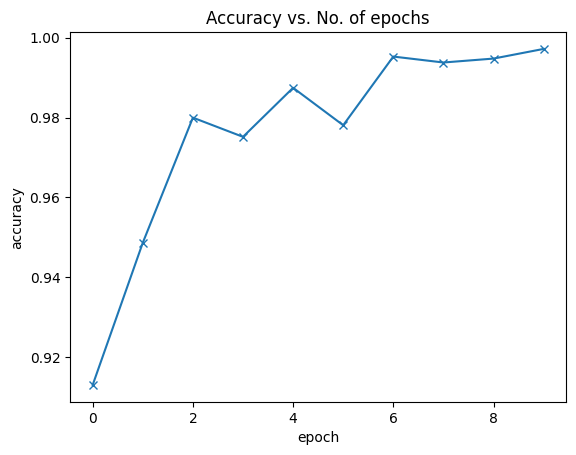

In [48]:
plot_accuracies(history)

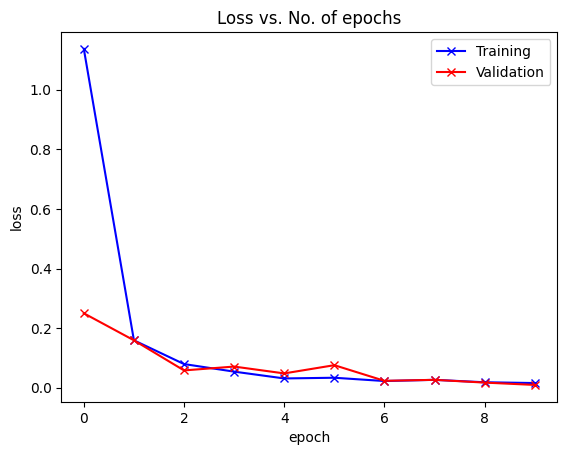

In [49]:
plot_losses(history)

In [51]:
torch.save(model.state_dict(), "CNN.pth")

29

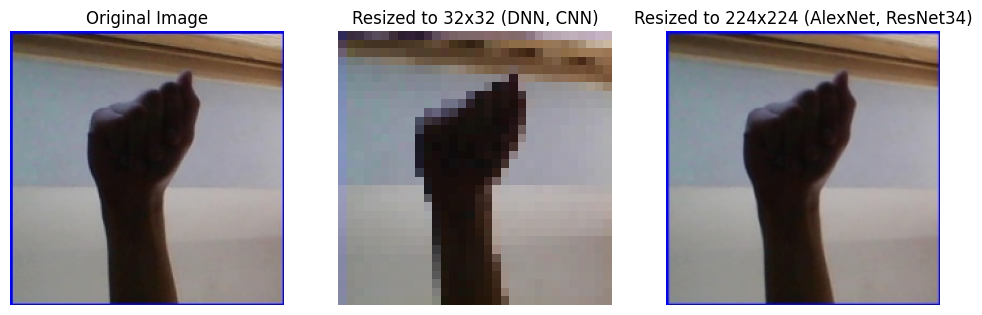

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the JPG file
image = cv2.imread("A1.jpg")

# Check if the image was successfully read
if image is not None:
    # Resize image to 32x32
    resized_32 = cv2.resize(image, (32, 32))

    # Resize image to 224x224
    resized_224 = cv2.resize(image, (224, 224))

    # Display images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Resized to 32x32 (DNN, CNN)")
    plt.imshow(cv2.cvtColor(resized_32, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Resized to 224x224 (AlexNet, ResNet34)")
    plt.imshow(cv2.cvtColor(resized_224, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()
else:
    print("Failed to read the image.")